In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from help_functions.evaluate_energymodels import evaluate_different_energymodels

from energy_consumption.help_functions.get_energy_data import get_data
from energy_consumption.help_functions.dummy_mapping import get_mappings
from energy_consumption.models.lasso_regression import get_lasso_forecasts
from energy_consumption.models.QR_mappings_interactions import get_QR_mappings_interactions
from energy_consumption.models.seasonal_QR_hh import get_seasonal_QR_hourly_holidays

In [3]:
energydata = get_data(wednesday_morning=True)

100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


In [4]:
energydata

,energy_consumption
date_time,
2021-12-20 00:00:00,49.57150
2021-12-20 01:00:00,47.99850
2021-12-20 02:00:00,47.46700
2021-12-20 03:00:00,47.96675
2021-12-20 04:00:00,49.45700
...,...
2023-11-22 08:00:00,65.75125
2023-11-22 09:00:00,67.40950
2023-11-22 10:00:00,68.26775


In [6]:
# Functions work
lasso = {
    'name': 'lasso regression and interaction',
    'function': get_lasso_forecasts
}
qr_km_interactions = {
    'name': 'seasonal model with k means mapping',
    'function': get_QR_mappings_interactions
}
seasonal_hh = {
    'name': 'seasonal model hourly and holidays',
    'function': get_seasonal_QR_hourly_holidays
}

models = [qr_km_interactions, lasso, seasonal_hh]
evaluation = evaluate_different_energymodels(
    models, energydata, last_x=10, years=False, months=False, weeks=True)

*********** Start the evaluation of model seasonal model with k means mapping***********
DatetimeIndex(['2023-11-17 12:00:00', '2023-11-17 16:00:00',
               '2023-11-17 20:00:00', '2023-11-18 12:00:00',
               '2023-11-18 16:00:00', '2023-11-18 20:00:00'],
              dtype='datetime64[ns]', name='date_time', freq=None)
DatetimeIndex(['2023-11-10 12:00:00', '2023-11-10 16:00:00',
               '2023-11-10 20:00:00', '2023-11-11 12:00:00',
               '2023-11-11 16:00:00', '2023-11-11 20:00:00'],
              dtype='datetime64[ns]', name='date_time', freq=None)


### Visualize Comparison 

1. Create a table that only contains the different scores of the different models

In [4]:
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score']
                      [m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1, keys=names)

2.  Plot the densities of the obtained scores

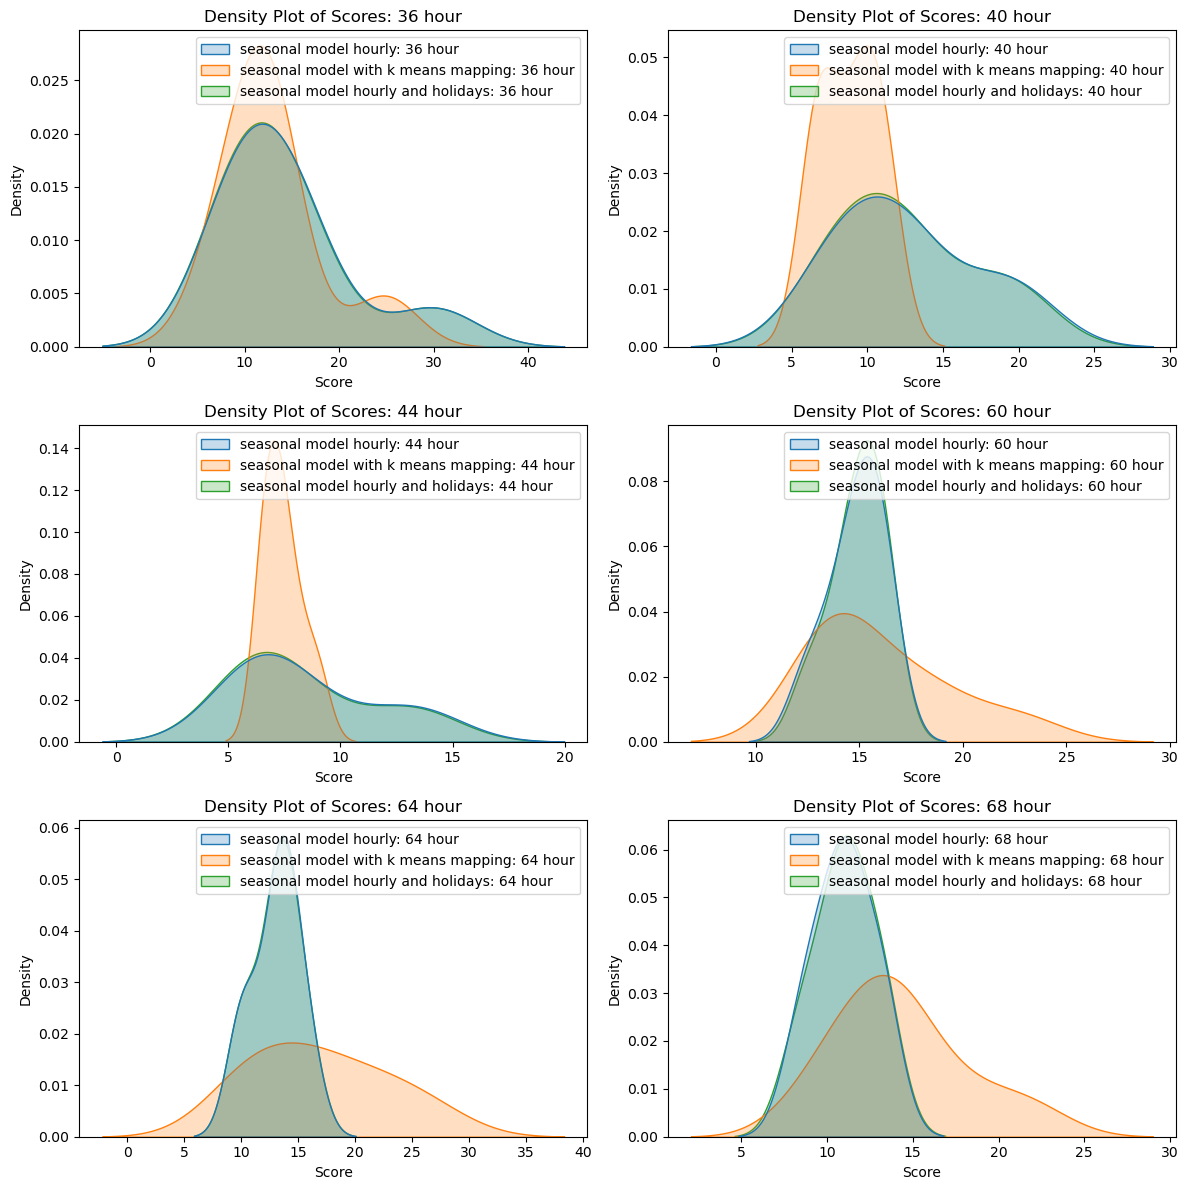

In [5]:
# Create subplots
fig, axes = plt.subplots(3,2, figsize=(12,12))

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Loop through each horizon
for i, h in enumerate(horizons):
    # Select columns related to the current horizon
    relevant_cols = [f'{m["name"]}: {h}' for m in models]

    # Filter the relevant data for the current horizon
    data_subset = score_df.loc[:, relevant_cols]

    # Create a KDE plot for the current horizon
    sns.kdeplot(data=data_subset, fill=True, ax=axes[i])

    # Set labels and title for each subplot
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Density Plot of Scores: {h}')

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Display the plots
plt.show()

Interpretation: Für Freitag ist timely besser, für Samstag nicht

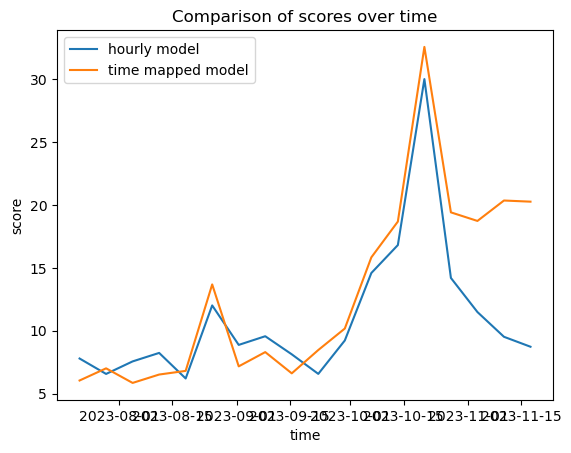

In [14]:
# Plot values from two columns over time
score_df_36_no_na = score_df[score_df['seasonal model hourly: 36 hour'].notna(
)]
# plt.plot(score_df_36_no_na.index, score_df_36_no_na['baseline: 36 hour'], label='baseline')
plt.plot(score_df_36_no_na.index,
         score_df_36_no_na['seasonal model hourly: 36 hour'], label='hourly model')

plt.plot(score_df_36_no_na.index,
         score_df_36_no_na['seasonal model with time mapping: 36 hour'], label='time mapped model')

# Adding labels and title
plt.xlabel('time')
plt.ylabel('score')
plt.title('Comparison of scores over time')

# Display legend
plt.legend()

# Show the plot
plt.show()